# Initialize Modules and Paths

In [1]:
# load modules

import numpy as np
import os
import h5py
from scipy.optimize import fsolve

import completeness

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'



In [2]:
# define paths

path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SP_cat_00 = path_main + 'catalogs/SP/0.0/'
path_SP_cat_02 = path_main + 'catalogs/SP/0.2/'


In [3]:
# define important parameters

volume_box = 100.0**3  # in Mpc^-3



# Define Functions

In [75]:
def compute_M(cat_obj):
    '''
    Computes average SFR over certain time interval
    from given cat_obj file. 
    
    Input:
      cat_obj       : object with SFH
      time_interval : time in Myr
      
    Output:
      SFR           : SFR in Msun/yr
      
    '''
    # load SFH for given time interval
    SFR_list = cat_obj['SFH/SFH_SFR'][:]
    time_list = cat_obj['SFH/SFH_time'][:]
    # compute mass
    mass_tot_list = np.trapz(SFR_list, time_list*10**6)
    return(mass_tot_list)


def compute_SFR(cat_obj, time_interval):
    '''
    Computes average SFR over certain time interval
    from given cat_obj file. 
    
    Input:
      cat_obj       : object with SFH
      time_interval : time in Myr
      
    Output:
      SFR           : SFR in Msun/yr
      
    '''
    # load SFH for given time interval
    idx_time_interval = (cat_obj['SFH/SFH_time'][:] >= (cat_obj['SFH/SFH_time'][:][-1]-time_interval))
    SFR_list = cat_obj['SFH/SFH_SFR'][:, idx_time_interval]
    time_list = cat_obj['SFH/SFH_time'][idx_time_interval]
    time_interval = (time_list[-1]-time_list[0])*10**6  # in yrs
    # compute mass
    mass_tot_list = np.trapz(SFR_list, time_list*10**6)
    # compute average SFR
    SFR = mass_tot_list/time_interval
    return(SFR)


def compute_Ms_Fct(SP_file_name, volume_box, bin_size=0.1, cumulative=False, redshift_in=None, completeness_correction=False, completeness_correction_type='parameterized'):
    '''
    input:
      SP_file_name:    hdf5 filename that contains luminosities
      volume_box:      volume of simulation box in Mpc^-3
      cumulative:      True/False for computing cumulative LF
      add_dust:        True/False for adding dust attenuation to UV mags
      redshift_in:     redshift considered, needed for add_dust and completeness_correction
      completeness_correction:  True/False for applying completeness correction
    '''
    cat_SP = h5py.File(SP_file_name, 'r')
    M_list = np.log10(compute_M(cat_SP))
    idx_good = np.isfinite(M_list)
    M_list = M_list[idx_good]
    M_bins = np.arange(np.max([6.0, np.min(M_list)]), np.min([11.5, np.max(M_list)]), bin_size)
    M_bins_center = M_bins[:-1] + 0.5*np.diff(M_bins)
    if completeness_correction:
        if (completeness_correction_type=='numerical'):
            weights = 10**completeness.get_completeness_correction_numerical(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
        elif (completeness_correction_type=='parameterized'):
            weights = 10**completeness.get_completeness_correction_parametrized(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
    else:
        weights = None
    hist, bin_edges = np.histogram(M_list, bins=M_bins, weights=weights)
    if cumulative:
        M_Fctcum = np.cumsum(hist[::-1])[::-1]/volume_box
        return(M_bins_center, M_Fctcum)
    else:
        M_Fct = hist/(np.diff(M_bins)*volume_box)
        return(M_bins_center, M_Fct)


def running_median_with_err(xval, yval):
    '''
    Running median
    '''
    bins = np.linspace(np.min(xval), np.max(xval), 20)
    bins_val = np.array([])
    bins_val_l = np.array([])
    bins_val_h = np.array([])
    for bin_cen in bins:
        select = (xval > bin_cen-0.1) & (xval < bin_cen+0.1)
        if (np.sum(select) > 10):
            bins_val = np.append(bins_val, np.percentile(yval[select], 50, axis=0))
            bins_val_l = np.append(bins_val_l, np.percentile(yval[select], 15.9, axis=0))
            bins_val_h = np.append(bins_val_h, np.percentile(yval[select], 84.1, axis=0))
        else:
            bins_val = np.append(bins_val, -99.)
            bins_val_l = np.append(bins_val_l, -99.)
            bins_val_h = np.append(bins_val_h, -99.)
    good_vals = (bins_val > -99.)
    return(bins[good_vals], bins_val[good_vals], bins_val_l[good_vals], bins_val_h[good_vals])



def plot_datapoints_observations_log(axes, dictionary, redshift, color, label):
    idx_no_upper_limit = (dictionary[redshift][2]>0.0)
    idx_upper_limit = ~idx_no_upper_limit
    # plot errorbar
    error_bar_neg = dictionary[redshift][2][idx_no_upper_limit]
    error_bar_pos = dictionary[redshift][3][idx_no_upper_limit]
    axes.errorbar(dictionary[redshift][0][idx_no_upper_limit], dictionary[redshift][1][idx_no_upper_limit], yerr=[error_bar_neg, error_bar_pos], fmt='o', color=color, capsize=3, label=label)
    # plot upper limit
    axes.errorbar(dictionary[redshift][0][idx_upper_limit], dictionary[redshift][1][idx_upper_limit], yerr=0.4, fmt='.', markersize=0, color=color, capsize=3, uplims=True)



# Comparison Stellar-to-Halo Mass Relation

In [16]:
Mh_Behroozi13 = [2.353e11, 3.210e11, 5.639e11, 7.352e11, 9.748e11, 1.331e12, 1.775e12, 3.135e12, 4.480e12, 6.709e12, 1.082e13, 1.762e13]
MM_Behroozi13 = [0.007, 0.010, 0.017, 0.020, 0.022, 0.022, 0.021, 0.016, 0.013, 0.009, 0.006, 0.004]


In [60]:
SP_file_name = path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5'
cat_SP = h5py.File(SP_file_name, 'r')
Mh_list = cat_SP['DM/DM_M'][:]
Ms_list = compute_M(cat_SP)
SFR_200_list = compute_SFR(cat_SP, 200.0)
SFR_10_list = compute_SFR(cat_SP, 10.0)


In [59]:
t = cat_SP['SFH/SFH_time'][:]
SFR = cat_SP['SFH/SFH_SFR'][:][10000]
print np.log10(np.trapz(SFR, t)*10**6)

8.259280692398479


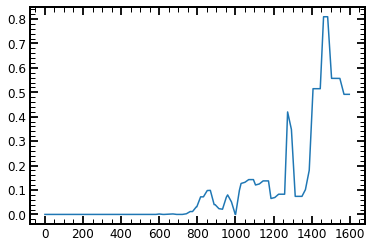

In [34]:
plt.plot(t, SFR, '-')
plt.show()

In [25]:
x_rm, y_rm, y_rm_l, y_rm_h = running_median_with_err(np.log10(Mh_list), np.log10(Ms_list/Mh_list))

/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


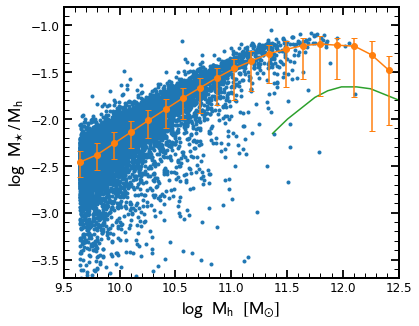

In [61]:
plot_every_other = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(np.log10(Mh_list)[::plot_every_other], np.log10(Ms_list/Mh_list)[::plot_every_other], '.', color='C0')
ax.errorbar(x_rm, y_rm, yerr=[y_rm-y_rm_l, y_rm_h-y_rm], fmt='o-', color='C1', capsize=3, zorder=10)
ax.plot(np.log10(Mh_Behroozi13), np.log10(MM_Behroozi13), '-', color='C2')

ax.set_xlabel(r'$\log\/\/\/\/\mathrm{M}_{\rm h}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{M}_{\star}\//\/\mathrm{M}_{\rm h}$', fontsize=18)

ax.set_xlim([9.5, 12.5])
ax.set_ylim([-3.7, -0.8])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'Ms_Mh_Relation.pdf', bbox_inches='tight')
plt.show()

# Comparison Stellar Mass Functions

In [53]:

M_Fct_obs_dict = {}

# z=4
M_list = np.array([7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])
phi_list = np.array([-1.57, -1.77, -2.00, -2.22, -2.52, -2.91, -3.37, -4.00, -4.54])
phi_err_list_neg = np.array([0.16, 0.14, 0.10, 0.09, 0.09, 0.05, 0.12, 0.25, 0.55])
phi_err_list_pos = np.array([0.21, 0.15, 0.13, 0.09, 0.09, 0.12, 0.09, 0.20, 0.34])
M_Fct_obs_dict['4'] = np.array([M_list, phi_list, phi_err_list_neg, phi_err_list_pos])



In [76]:
M_bins_center_z4, M_fct_model_z4 = compute_Ms_Fct(path_SP_cat_00 + 'SFH_z4_constant_with_L.hdf5', volume_box, bin_size=0.1, cumulative=False, redshift_in=None, completeness_correction=False, completeness_correction_type='parameterized')


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


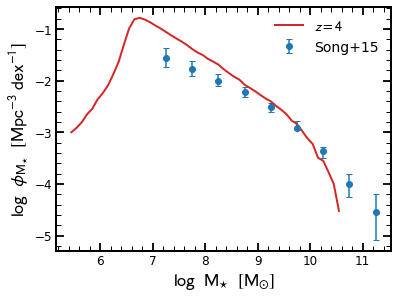

In [80]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
plot_datapoints_observations_log(ax, M_Fct_obs_dict, '4', 'C0', 'Song+15')

# Model
ax.plot(M_bins_center_z4-0.6, np.log10(M_fct_model_z4), '-', color='C3', lw=2, label=r'$z=4$')


ax.set_xlabel(r'$\log\/\/\/\/\mathrm{M}_{\star}\/\/\/\/[\mathrm{M_{\odot}}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm M_{\star}}\/\/\/\/[\mathrm{Mpc}^{-3}\/\/\mathrm{dex}^{-1}]$', fontsize=18)

#ax.set_xlim([-1.0, 3.0])
#ax.set_ylim([-5.5, -0.7])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'Ms_Fct_evolution.pdf', bbox_inches='tight')
plt.show()


# Star-Forming Main Sequence

/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


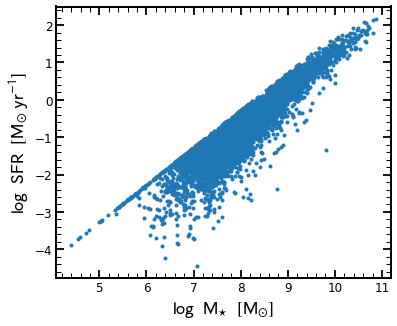

In [79]:
plot_every_other = 10

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(np.log10(Ms_list)[::plot_every_other], np.log10(SFR_200_list)[::plot_every_other], '.', color='C0')
#ax.plot(np.log10(Ms_list)[::plot_every_other], np.log10(SFR_10_list)[::plot_every_other], '.', color='C1')
#ax.errorbar(x_rm, y_rm, yerr=[y_rm-y_rm_l, y_rm_h-y_rm], fmt='o-', color='C1', capsize=3, zorder=10)
#ax.plot(np.log10(Mh_Behroozi13), np.log10(MM_Behroozi13), '-', color='C2')

ax.set_xlabel(r'$\log\/\/\/\/\mathrm{M}_{\star}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{SFR}\/\/\/\/[\mathrm{M}_{\odot}\/\/\mathrm{yr}^{-1}]$', fontsize=18)

#ax.set_xlim([9.5, 11.5])
#ax.set_ylim([0.0, 2.5])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'MS_Relation.pdf', bbox_inches='tight')
plt.show()